In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.5 MB/s eta 0:00:00


In [ ]:
!pip install openpyxl

In [ ]:
# 📌 환경 준비 (최초 1회만 실행)
!pip install category_encoders openpyxl xgboost seaborn --quiet

# 📌 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# ✅ Step 1: 설정 (여기만 바꾸면 됨!)
features = ['weaptype1_txt', 'attacktype1_txt', 'targtype1_txt', 'weekday', 'imonth', 'provstate']
target = 'success'

# 📌 데이터 로드 및 미국 필터링
df = pd.read_excel('/content/plz.xlsx')
df_us = df[df['country_txt'] == 'United States'].copy().head(2000)

# ✅ weekday 파생
df_us['date'] = pd.to_datetime(
    dict(year=df_us['iyear'], month=df_us['imonth'], day=df_us['iday']),
    errors='coerce'
)
df_us['weekday'] = df_us['date'].dt.dayofweek

# ✅ 피처/타겟 분리
X = df_us[features].copy()
y = df_us[target]

# ✅ Step 4: 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Step 5: 인코딩 그룹 지정
onehot_cols = ['weaptype1_txt', 'attacktype1_txt', 'targtype1_txt', 'weekday']
ordinal_cols = ['imonth']
target_cols = ['provstate']

# ✅ One-Hot Encoding
X_train_onehot = pd.get_dummies(X_train[onehot_cols], drop_first=True)
X_val_onehot = pd.get_dummies(X_val[onehot_cols], drop_first=True)
X_val_onehot = X_val_onehot.reindex(columns=X_train_onehot.columns, fill_value=0)

# ✅ Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
X_train_ordinal = pd.DataFrame(
    ordinal_encoder.fit_transform(X_train[ordinal_cols]),
    columns=ordinal_cols,
    index=X_train.index
)
X_val_ordinal = pd.DataFrame(
    ordinal_encoder.transform(X_val[ordinal_cols]),
    columns=ordinal_cols,
    index=X_val.index
)

# ✅ Target Encoding
target_encoder = TargetEncoder()
X_train_target = target_encoder.fit_transform(X_train[target_cols], y_train)
X_val_target = target_encoder.transform(X_val[target_cols])

# ✅ Step 6: 최종 인코딩 데이터 결합
X_train_encoded = pd.concat([X_train_onehot, X_train_ordinal, X_train_target], axis=1)
X_val_encoded = pd.concat([X_val_onehot, X_val_ordinal, X_val_target], axis=1)

# ✅ Step 7: 간단한 모델 테스트 (선택)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_encoded, y_train)
preds = model.predict(X_val_encoded)

print("✅ Accuracy:", accuracy_score(y_val, preds))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:41:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 0.8095238095238095


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

sns.set_theme(style="whitegrid", font="NanumGothic")
plt.rcParams['axes.unicode_minus'] = False

# ✅ 모든 결측치를 "unknown"으로 먼저 대체
df_us = df_us.fillna("unknown")

# 2. 1990년 이후 데이터 필터링
df_us = df_us[df_us['iyear'] >= 1990].copy()

# 3. nkill, nwound를 숫자형으로 변환 후 결측치는 0으로 대체
df_us['nkill'] = pd.to_numeric(df_us['nkill'], errors='coerce').fillna(0)
df_us['nwound'] = pd.to_numeric(df_us['nwound'], errors='coerce').fillna(0)

# 4. 총 피해(casualties) 계산
df_us['casualties'] = df_us['nkill'] + df_us['nwound']

#중복 제거 전 행 수 확인
print(f"중복 제거 전: {df_us.shape[0]} rows")

#'eventid'와 'Unnamed: 0' 제외한 컬럼 기준으로 중복 제거
df_1990 = df_us.drop_duplicates(subset=[col for col in df_us.columns if col not in ['eventid', 'Unnamed: 0']])

#중복 제거 후 행 수 확인
print(f"중복 제거 후: {df_1990.shape[0]} rows")

#'Unnamed: 0' 컬럼 삭제
df_1990.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# 전처리 함수 호출 (최상단에서 실행)
# df_1990 = load_and_preprocess_data('/content/plz.xlsx')

중복 제거 전: 1155 rows
중복 제거 후: 1130 rows


<ipython-input-7-8cd43a0983c7>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1990.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')


In [ ]:
# 지역명 한글 매핑
region_mapping = {
    "Middle East & North Africa": "중동 및 북아프리카",
    "South Asia": "남아시아",
    "Southeast Asia": "동남아시아",
    "Sub-Saharan Africa": "사하라 이남 아프리카",
    "Eastern Europe": "동유럽",
    "Western Europe": "서유럽",
    "East Asia": "동아시아",
    "Central Asia": "중앙아시아",
    "North America": "북아메리카",
    "South America": "남아메리카",
    "Central America & Caribbean": "중앙아메리카 및 카리브해",
    "Australasia & Oceania": "오세아니아"
}

# 공격 유형 한글 매핑
attack_mapping = {
    "Bombing/Explosion": "폭탄/폭발",
    "Armed Assault": "무장공격",
    "Unarmed Assault": "비무장 공격",
    "Facility/Infrastructure Attack": "시설/인프라 공격",
    "Hijacking": "납치",
    "Hostage Taking (Kidnapping)": "인질극(납치)",
    "Hostage Taking (Barricade Incident)": "인질극(바리케이드)",
    "Assassination": "암살",
    "Unknown": "알 수 없음"
}

target_gov_or_peo = {
    # 군사/정부 관련
    'Government (Diplomatic)': '군사/정부',
    'Government (General)': '군사/정부',
    'Police': '군사/정부',
    'Military': '군사/정부',
    'Violent Political Party': '군사/정부',

    # 공공시설/민간 대상
    'Private Citizens & Property': '공공시설/민간',
    'Journalists & Media': '공공시설/민간',
    'Airports & Aircraft': '공공시설/민간',
    'Business': '공공시설/민간',
    'Educational Institution': '공공시설/민간',
    'Utilities': '공공시설/민간',
    'Transportation': '공공시설/민간',
    'Tourists': '공공시설/민간',
    'NGO': '공공시설/민간',
    'Telecommunication': '공공시설/민간',
    'Food or Water Supply': '공공시설/민간',
    'Terrorists/Non-State Militia': '공공시설/민간',
    'Other': '공공시설/민간',
    'Maritime': '공공시설/민간',
    'Abortion Related': '공공시설/민간',
    'Religious Figures/Institutions': '공공시설/민간',
    'Unknown': '공공시설/민간'
}

target_mapping = {
    "Abortion Related": "낙태 시술소 관련",
    "Airports & Aircraft": "공항 및 항공기",
    "Business": "사업체",
    "Educational Institution": "교육 기관",
    "Food or Water Supply": "식량 또는 수도",
    "Government (Diplomatic)": "정부 (외교)",
    "Government (General)": "정부 (일반)",
    "Journalists & Media": "언론 및 미디어",
    "Maritime": "해상",
    "Military": "군",
    "NGO": "비정부기구",
    "Other": "기타",
    "Police": "경찰",
    "Private Citizens & Property": "민간인 및 재산",
    "Religious Figures/Institutions": "종교 인물/기관",
    "Telecommunication": "통신",
    "Terrorists/Non-State Militia": "테러리스트/비국가 민병대",
    "Tourists": "관광객",
    "Transportation": "교통",
    "Unknown": "알 수 없음",
    "Utilities": "공공시설",
    "Violent Political Party": "폭력적 정치단체"
}

In [ ]:
import pandas as pd

# 예시: df는 원본 데이터프레임

# 공격 유형별 성공 비율 계산
success_ratio = df.groupby('attacktype1_txt')['success'].mean().reset_index()

# 성공 비율 컬럼 이름 변경
success_ratio.columns = ['공격 유형', '성공 비율']

# 출력
print(success_ratio)

                                 공격 유형     성공 비율
0                        Armed Assault  0.923464
1                        Assassination  0.692095
2                    Bombing/Explosion  0.864752
3       Facility/Infrastructure Attack  0.953362
4                            Hijacking  0.888333
5  Hostage Taking (Barricade Incident)  0.991031
6          Hostage Taking (Kidnapping)  0.981151
7                      Unarmed Assault  0.872896
8                              Unknown  0.789781


성공률



<ipython-input-10-0b9cae150d11>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1990[col] = pd.to_numeric(df_1990[col], errors='coerce')


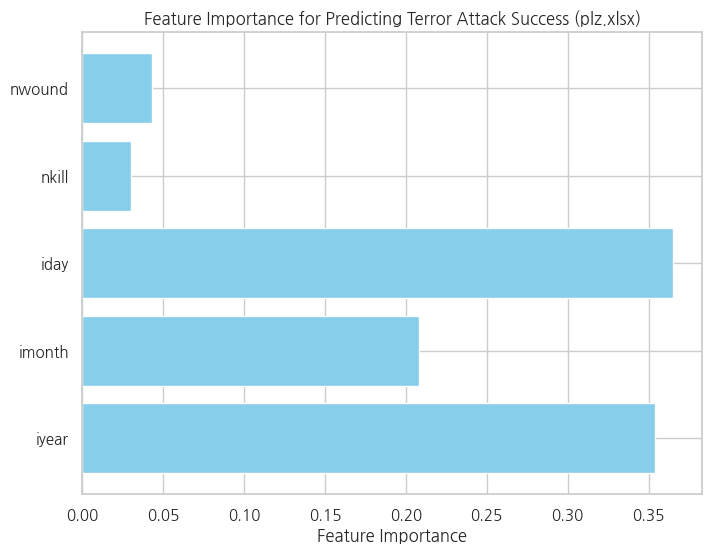

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 2. 사용할 피처와 타겟 변수 선택
features = ['iyear', 'imonth', 'iday', 'nkill', 'nwound']
target = 'success'

# 3. 필요한 컬럼에 결측치가 있는 행 제거
# df_clean = df_plz.dropna(subset=features + [target])

# 4. 각 피처 컬럼을 숫자형으로 변환 (필요한 경우)
for col in features:
    df_1990[col] = pd.to_numeric(df_1990[col], errors='coerce')
df_clean = df_1990.dropna(subset=features)

# 5. X(피처)와 y(타겟) 분리
X = df_clean[features]
y = df_clean[target]

# 6. 데이터 분할 (훈련/테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 7. 랜덤 포레스트 분류기 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 8. 피처 중요도 추출
importances = rf.feature_importances_
feature_names = X.columns

# 9. 피처 중요도 시각화 (수평 막대 그래프)
plt.figure(figsize=(8,6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting Terror Attack Success (plz.xlsx)')
plt.show()

미국에 대한 것만 분석

In [ ]:
# 미국에 해당하는 데이터만 필터링
df_usa = df[df['country_txt'] == 'United States']

In [ ]:
# NaN을 제외하고 시각화
us_data_non_nan = df_usa[df_usa['targtype1_txt'].notna()]


##미국 전체 테러 성공률

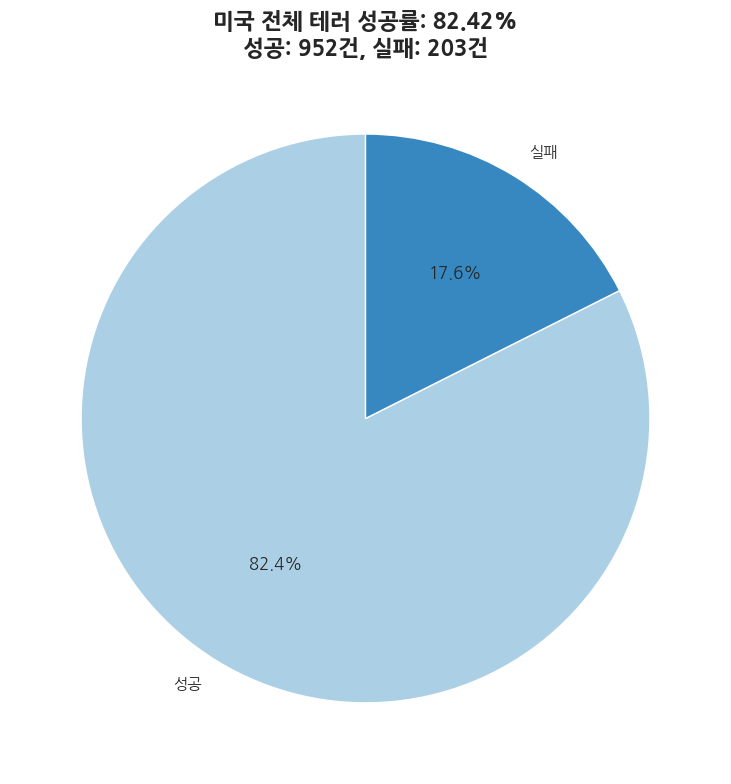

In [ ]:
# 미국 전체 테러 성공률 계산
usa_success_rate = df_usa['success'].mean() * 100
usa_success_count = df_usa[df_usa['success'] == 1].shape[0]  # 성공한 테러 사건 수
usa_failure_count = df_usa[df_usa['success'] == 0].shape[0]  # 실패한 테러 사건 수
total_usa_attacks = df_usa.shape[0]  # 총 테러 사건 수

# 성공률
labels = ['성공', '실패']
sizes = [usa_success_rate, 100 - usa_success_rate]
colors = sns.color_palette("Blues", len(labels))

# 파이차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# 제목에 백분율과 갯수 표시
plt.title(f'미국 전체 테러 성공률: {usa_success_rate:.2f}%\n'
          f'성공: {usa_success_count}건, 실패: {usa_failure_count}건',
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# 전체 데이터에서 무기 유형별 테러 건수 계산
weapon_counts = df['weaptype1_txt'].value_counts().reset_index()
weapon_counts.columns = ['무기 유형', '테러 건수']

# 표 형태로 출력
weapon_counts

,무기 유형,테러 건수
0,Explosives,87103
1,Firearms,54244
2,Unknown,17022
3,Incendiary,10289
4,Melee,4090
5,Chemical,298
6,Vehicle (not to include vehicle-borne explosiv...,185
7,Sabotage Equipment,169
8,Other,127
9,Biological,30


무기 유형별 사건 비율

In [ ]:
import pandas as pd
import plotly.express as px

# 전체 데이터에서 무기 유형별 테러 건수 계산
weapon_counts = df['weaptype1_txt'].value_counts().reset_index()
weapon_counts.columns = ['무기 유형', '테러 건수']

# 전체 테러 건수 계산 및 비율 (%) 컬럼 생성
total_attacks = weapon_counts['테러 건수'].sum()
weapon_counts['비율 (%)'] = weapon_counts['테러 건수'] / total_attacks * 100

# 트리맵 시각화 (무기 유형별 테러 사건 비율)
fig = px.treemap(
    weapon_counts,
    path=['무기 유형'],
    values='비율 (%)',   # 새로 생성한 "비율 (%)" 컬럼 사용
    color='비율 (%)',
    color_continuous_scale="Viridis",  # 부드러운 색상 팔레트
    title="미국: 무기 유형별 테러 사건 비율",
    labels={"무기 유형": "무기 유형", "비율 (%)": "테러 사건 비율 (%)"}
)

fig.show()

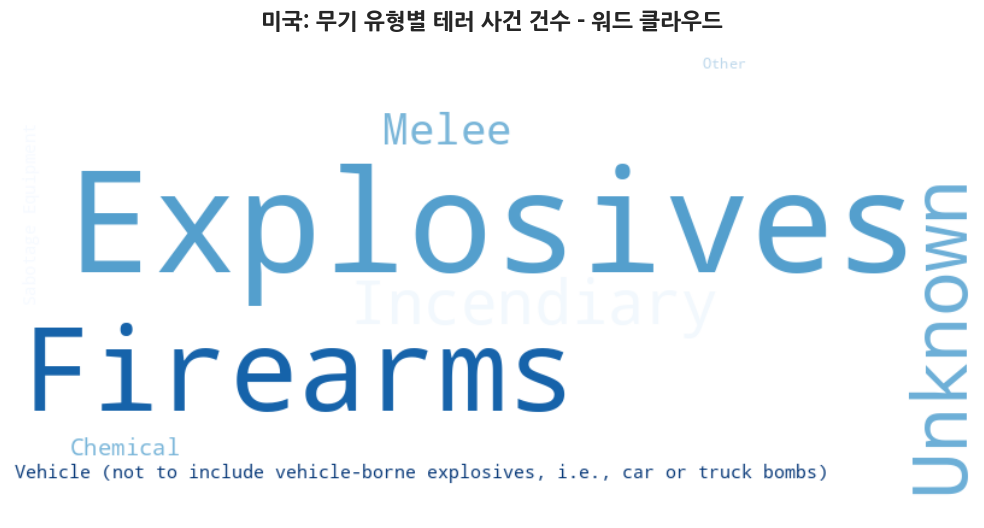

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 정확한 무기 유형별 테러 건수 입력
word_freq = {
    'Explosives': 86986,
    'Firearms': 54143,
    'Unknown': 16935,
    'Incendiary': 10267,
    'Melee': 4066,
    'Chemical': 297,
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)': 184,
    'Sabotage Equipment': 168,
    'Other': 123,
    'Fake Weapons': 30,
    'Biological': 28,
    'Radiological': 10
}

# 워드 클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Blues", max_words=50, min_font_size=10).generate_from_frequencies(word_freq)

# 워드 클라우드 출력
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("미국: 무기 유형별 테러 사건 건수 - 워드 클라우드", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

###무기유형별 성공률

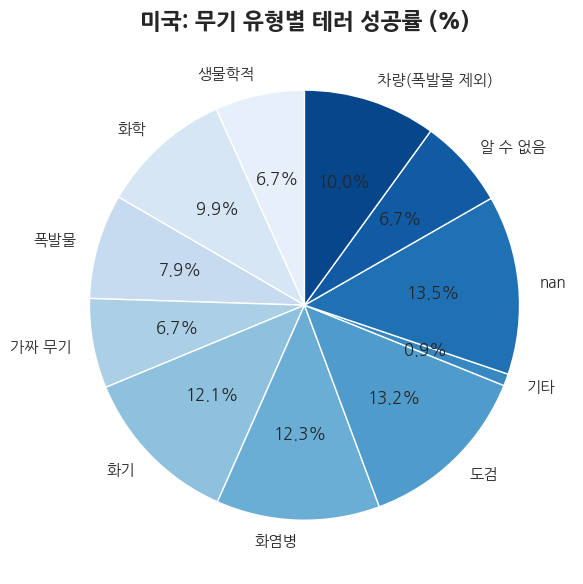

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 무기 유형별 테러 성공률을 백분율로 변환
weapon_success_rate = df_usa.groupby('weaptype1_txt')['success'].mean().reset_index()
weapon_success_rate['성공률 (%)'] = weapon_success_rate['success'] * 100

# 무기 유형 한글화 매핑
weapon_translation = {
    'Chemical': '화학',
    'Explosives': '폭발물',
    'Fake Weapons': '가짜 무기',
    'Firearms': '화기',
    'Incendiary': '화염병',
    'Melee': '도검',
    'Other': '기타',
    'Radiological': '방사능',
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)': '차량(폭발물 제외)',
    'Biological': '생물학적',
    'Unknown': '알 수 없음'
}

weapon_success_rate['무기 유형'] = weapon_success_rate['weaptype1_txt'].map(weapon_translation)

# 파이차트 시각화
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues", len(weapon_success_rate))
plt.pie(weapon_success_rate['성공률 (%)'], labels=weapon_success_rate['무기 유형'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('미국: 무기 유형별 테러 성공률 (%)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

# 버블 차트 시각화 (무기 유형별 성공률)
fig = px.scatter(
    weapon_success_rate,
    x='무기 유형',
    y='성공률 (%)',
    size='성공률 (%)',
    color='성공률 (%)',
    color_continuous_scale="Blues",  # 부드러운 색상 팔레트
    size_max=100,
    title="미국: 무기 유형별 테러 성공률"
)

fig.show()

##공격 유형별 성공 비율

##타겟대상별 공격 유형

In [ ]:
# NaN 값을 가진 행을 제거한 데이터에서 'targtype1_txt' 컬럼에 포함된 유효한 타겟 대상들만 추출
valid_target_types = df_usa['targtype1_txt'].dropna().unique()

# 유효한 타겟 대상들 출력
print("유효한 타겟 대상 목록:")
for target in valid_target_types:
    print(target)

유효한 타겟 대상 목록:
Utilities
Military
Religious Figures/Institutions
Educational Institution
Government (General)
Business
Abortion Related
Private Citizens & Property
Journalists & Media
Terrorists/Non-State Militia
Government (Diplomatic)
Telecommunication
Police
Transportation
Airports & Aircraft
Unknown
Violent Political Party
Tourists
Food or Water Supply
NGO
Maritime
Other


In [ ]:
# 유효한 타겟 대상 목록
valid_target_types = [
    'Utilities', 'Military', 'Religious Figures/Institutions', 'Educational Institution',
    'Government (General)', 'Business', 'Abortion Related', 'Private Citizens & Property',
    'Journalists & Media', 'Terrorists/Non-State Militia', 'Government (Diplomatic)',
    'Telecommunication', 'Police', 'Transportation', 'Airports & Aircraft', 'Unknown',
    'Violent Political Party', 'Tourists', 'Food or Water Supply', 'NGO', 'Maritime', 'Other'
]

# 해당 타겟 대상 목록만 필터링하여 출력
filtered_targets = df_usa[df_usa['targtype1_txt'].isin(valid_target_types)]

# 필터링된 타겟 대상만 출력
filtered_target_types = filtered_targets['targtype1_txt'].dropna().unique()

# 출력
print("유효한 타겟 대상 목록:")
for target in filtered_target_types:
    print(target)

유효한 타겟 대상 목록:
Utilities
Military
Religious Figures/Institutions
Educational Institution
Government (General)
Business
Abortion Related
Private Citizens & Property
Journalists & Media
Terrorists/Non-State Militia
Government (Diplomatic)
Telecommunication
Police
Transportation
Airports & Aircraft
Unknown
Violent Political Party
Tourists
Food or Water Supply
NGO
Maritime
Other


<ipython-input-21-216570e37911>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




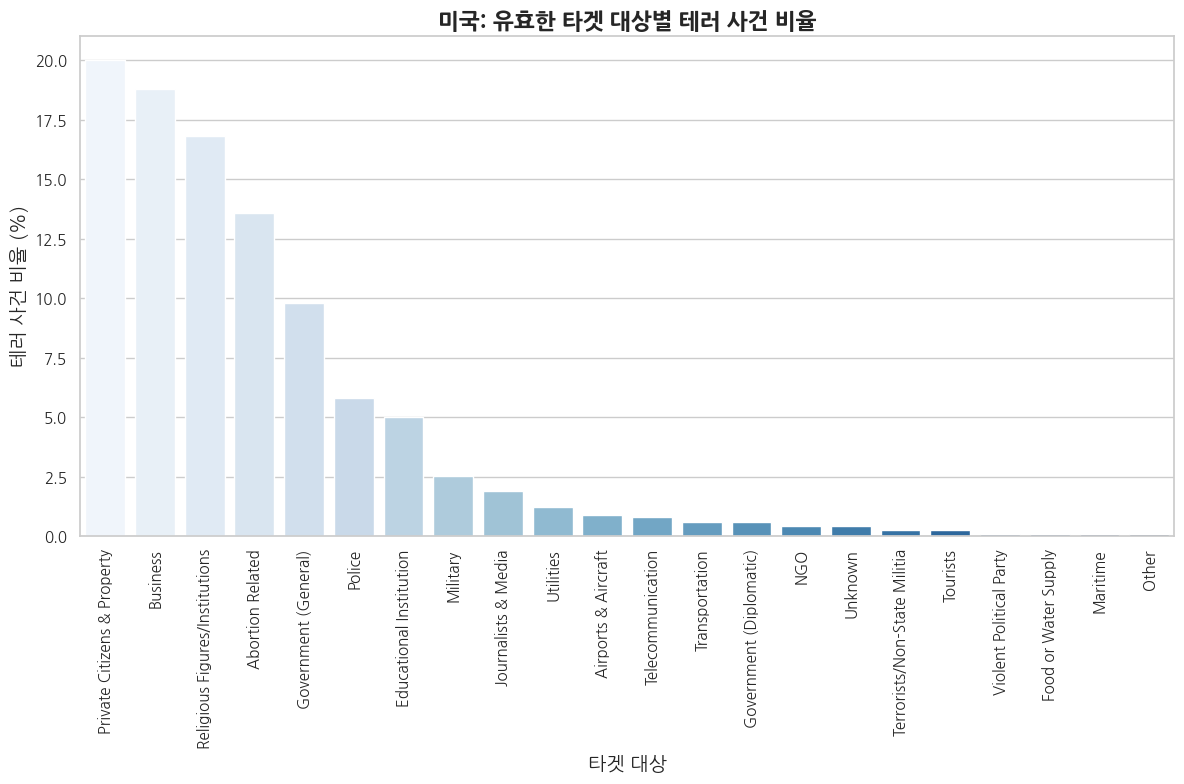

In [ ]:
# NaN 값을 제외한 데이터만 사용
us_data_non_nan = df_usa.dropna(subset=['targtype1_txt'])

# 유효한 타겟 대상만 필터링
filtered_targets = us_data_non_nan[us_data_non_nan['targtype1_txt'].isin(valid_target_types)]

# 타겟 대상별 사건 수 계산
target_counts = filtered_targets['targtype1_txt'].value_counts()

# 전체 테러 사건 수 계산
total_attacks = target_counts.sum()

# 타겟별 사건 비율 계산
target_percentage = (target_counts / total_attacks) * 100

# 막대그래프 (Bar Chart) 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=target_percentage.index, y=target_percentage.values, palette='Blues')
plt.xticks(rotation=90)  # x축 라벨을 90도 회전시켜서 보기 좋게 만듦
plt.title('미국: 유효한 타겟 대상별 테러 사건 비율', fontsize=16, fontweight='bold')
plt.xlabel('타겟 대상', fontsize=14)
plt.ylabel('테러 사건 비율 (%)', fontsize=14)
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
# 기존에 계산한 target_percentage Series를 데이터프레임으로 변환
target_percentage_df = target_percentage.reset_index()
target_percentage_df.columns = ['targtype1_txt', '테러 사건 비율 (%)']

# 트리맵 시각화 (타겟 대상별 테러 사건 비율) - 상위 데이터 사용
fig = px.treemap(
    target_percentage_df,
    path=['targtype1_txt'],  # 타겟 대상
    values='테러 사건 비율 (%)',  # 테러 사건 비율
    color='테러 사건 비율 (%)',  # 색상도 사건 비율로 설정
    color_continuous_scale="Blues",  # 색상 팔레트
    title="미국: 유효한 타겟 대상별 테러 사건 비율",
    labels={"targtype1_txt": "타겟 대상", "테러 사건 비율 (%)": "테러 사건 비율 (%)"}
)

fig.show()

In [ ]:
# import plotly.express as px
# import pandas as pd

# # NaN 값을 가진 행을 제거
# target_percentage_df_clean = target_percentage_df.dropna(subset=['targtype1_txt'])

# # 트리맵 시각화 (타겟 대상별 테러 사건 비율)
# fig = px.treemap(
#     target_percentage_df_clean,
#     path=['targtype1_txt'],  # 타겟 대상
#     values='테러 사건 비율 (%)',  # 테러 사건 비율
#     color='테러 사건 비율 (%)',  # 색상도 사건 비율로 설정
#     color_continuous_scale="sunset",  # 파스텔 색상 팔레트
#     title="미국: 유효한 타겟 대상별 테러 사건 비율",
#     labels={"targtype1_txt": "타겟 대상", "테러 사건 비율 (%)": "테러 사건 비율 (%)"},  # 한글 레이블 추가
#     hover_data={'테러 사건 비율 (%)': True}  # 퍼센트를 hover에 표시
# )

# # 퍼센트도 텍스트로 표시
# fig.update_traces(textinfo="label+percent entry")

# fig.show()

##요일별 테러 성공률

<ipython-input-24-e11dff77fbcc>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-e11dff77fbcc>:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




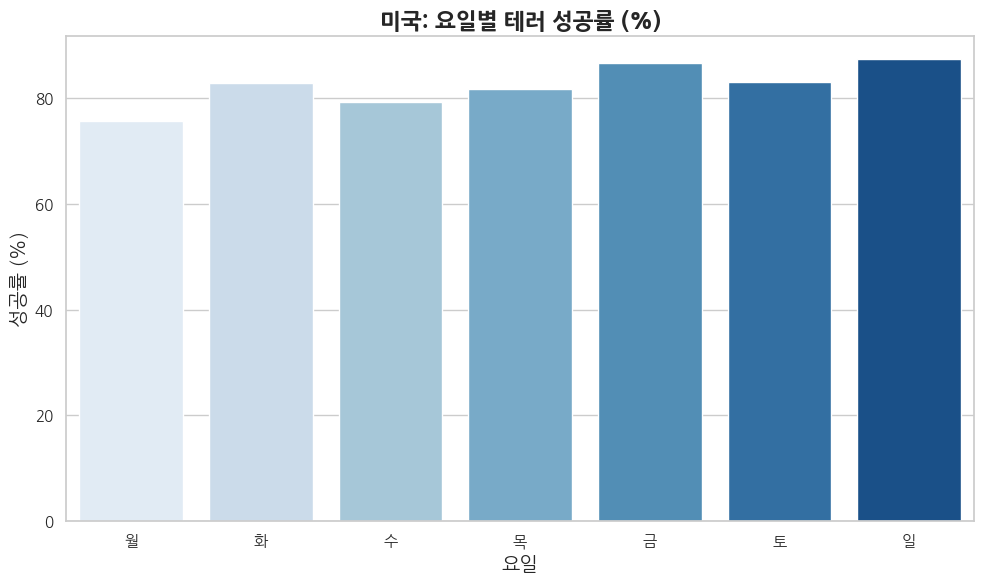

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 'iday'가 0인 행 제거 (유효한 날짜만 사용)
df_usa = df_usa[df_usa['iday'] > 0]

# 'iyear', 'imonth', 'iday' 컬럼을 문자열로 결합하여 날짜 생성
df_usa['date'] = pd.to_datetime(df_usa['iyear'].astype(str) + '-' +
                                df_usa['imonth'].astype(str) + '-' +
                                df_usa['iday'].astype(str), errors='coerce')

# 생성된 날짜 중 NaT가 있는 경우 제거
df_usa = df_usa.dropna(subset=['date'])

# 요일 추출 (0=월요일, 6=일요일)
df_usa['weekday'] = df_usa['date'].dt.weekday

# 요일별 테러 성공률 계산
weekday_success_rate = df_usa.groupby('weekday')['success'].mean().reset_index()

# 요일을 한글로 변환
weekday_success_rate['요일'] = weekday_success_rate['weekday'].map({
    0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'
})

# 백분율로 변환
weekday_success_rate['성공률 (%)'] = weekday_success_rate['success'] * 100

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='요일', y='성공률 (%)', data=weekday_success_rate, palette='Blues')
plt.title('미국: 요일별 테러 성공률 (%)', fontsize=16, fontweight='bold')
plt.xlabel('요일', fontsize=14)
plt.ylabel('성공률 (%)', fontsize=14)
plt.tight_layout()
plt.show()

테러 요일별 비율

<ipython-input-25-c0090dc4821c>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-c0090dc4821c>:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




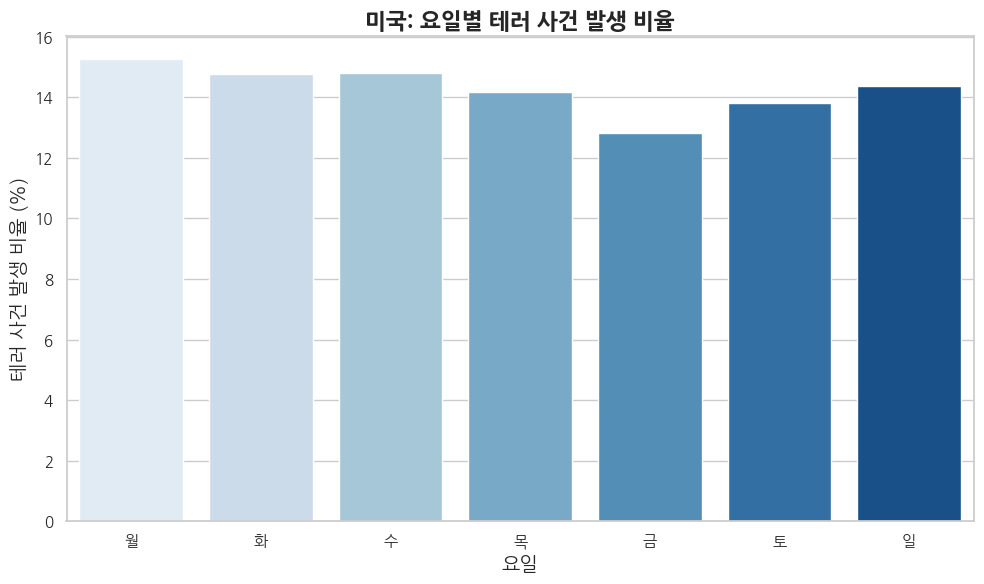

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 'iyear', 'imonth', 'iday' 컬럼에 NaN 값이 있는 행을 제거
df_usa_clean = df.dropna(subset=['iyear', 'imonth', 'iday'])

# 'iday'가 0인 경우는 날짜로 사용할 수 없으므로 이를 제거
df_usa_clean = df_usa_clean[df_usa_clean['iday'] > 0]

# 'iyear', 'imonth', 'iday'가 모두 숫자형인지 확인하고, 형식이 맞지 않으면 처리
df_usa_clean[['iyear', 'imonth', 'iday']] = df_usa_clean[['iyear', 'imonth', 'iday']].astype(int)

# 날짜를 생성 (year, month, day 순으로 제공된다고 가정)
df_usa_clean['date'] = pd.to_datetime(df_usa_clean['iyear'].astype(str) + '-' +
                                       df_usa_clean['imonth'].astype(str) + '-' +
                                       df_usa_clean['iday'].astype(str),
                                       errors='coerce')

# 날짜 생성 중 오류가 있을 경우, 'NaT'로 처리된 항목은 제거
df_usa_clean = df_usa_clean.dropna(subset=['date'])

# 요일 추출 (0=월요일, 6=일요일)
df_usa_clean['weekday'] = df_usa_clean['date'].dt.weekday

# 요일별 테러 사건 수 계산
weekday_counts = df_usa_clean['weekday'].value_counts().sort_index()

# 전체 테러 사건 수 계산
total_attacks = weekday_counts.sum()

# 요일별 테러 사건 비율 계산
weekday_percentage = (weekday_counts / total_attacks) * 100

# 요일별 비율 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=weekday_percentage.index, y=weekday_percentage.values, palette='Blues')
plt.xticks(ticks=range(7), labels=['월', '화', '수', '목', '금', '토', '일'])  # 요일 한글화
plt.title('미국: 요일별 테러 사건 발생 비율', fontsize=16, fontweight='bold')
plt.xlabel('요일', fontsize=14)
plt.ylabel('테러 사건 발생 비율 (%)', fontsize=14)
plt.tight_layout()  # 레이아웃 조정
plt.show()

1. 주말(금·토·일) 특성
	•	보안 공백: 일반적으로 평일에는 관공서·기업 보안이 체계적으로 운영되지만, 주말이나 휴일에는 근무 인력이 줄어드는 경향이 있어 테러의 “성공률”이 올라갈 수 있습니다.
	•	목표물 특성: 테러가 주말 대규모 행사나 종교 행사(예: 일요일 미사)를 노리는 경우가 많아, 성공률이 높게 잡힐 수 있습니다.

2. 평일(월목) 대비 주말(금일) 행동 패턴
	•	공격 표적: 평일에는 군·경찰·정부시설 같은 보안이 강화된 목표를 공격하려다 실패하는 사례가 많을 수 있습니다.
	•	주말 공공장소 공격: 반대로 주말엔 인파가 몰리는 쇼핑몰, 축제 등 ‘소프트 타겟(Soft Target)’을 노려 성공 확률이 올라갈 수 있습니다.

3. 데이터 편향 혹은 특정 대형 사건의 영향
	•	대형 테러가 특정 요일(예: 일요일)에 집중되어 그 해 성공률 통계가 급격히 상승했을 가능성도 있습니다.
	•	통계가 큰 사건 몇 건에 의해 왜곡될 수 있으므로, 사건 수와 성공률을 함께 해석해야 합니다.

4. 테러 조직 전략
	•	상징적 요일 선택: 일요일은 종교·휴식 의미가 강해 충격효과가 크고, 금요일(이슬람권 ‘주말’) 등 종교적 의미가 있는 요일에 공격이 집중되는 경향도 있습니다.
	•	보안 패턴 파악: 테러 조직이 요일별 보안 공백을 파악해 성공 확률이 높은 요일을 택할 수 있습니다.

⸻

결론
	•	요일별 테러 발생 비율은 테러 조직이 특정 요일에 더 많이 공격을 시도하는 패턴을 보여줍니다.
	•	요일별 테러 성공률은 그 시도 중 얼마나 “성공”으로 기록됐는지를 의미하며, 주말이나 일요일에 높게 나타나는 이유는 보안 인력 감소, 대형 사건의 영향, 소프트 타겟 공격 등이 복합적으로 작용했을 가능성이 큽니다.

결국, **“일요일 테러 성공률이 높다”**는 것은 단순히 일요일에 더 많이 성공한다기보다는,
	•	(1) 일요일에 특정 목표물이 취약할 수 있고,
	•	(2) 대형 사건이 일요일에 집중되었을 가능성,
	•	(3) 주말 보안 공백 등의 요인이 종합적으로 작용했기 때문이라고 해석할 수 있습니다.

미국 테러 단체와 활동 지역

In [ ]:
import pandas as pd
import plotly.express as px

# 테러 단체 한글화 매핑
gname_translation = {
    'Pedro Albizu Campos Revolutionary Forces': '페드로 알비주 캄포스 혁명군',
    'Unknown': '알 수 없음',
    'Jamaat-al-Fuqra': '자마트-알-푸크라',
    'Up the IRS, Inc': 'IRS 반대 단체',
    'Earth Night Action Group': '지구의 밤 행동 그룹',
    'Environmentalists': '환경 운동가들',
    'Anti-Abortion extremists': '반낙태 극단주의자들',
    'Anti-Environmentalists': '반환경 운동가들',
    'Puerto Rican Nationalists': '푸에르토리코 민족주의자들',
    'Ku Klux Klan': '쿠 클럭스 클랜',
    'Muslim extremists': '이슬람 극단주의자들',
    'Popular Liberation Army (Puerto Rico)': '인기 해방군(푸에르토리코)',
    'Christian Liberation Army': '기독교 해방군',
    'Tontons Macoutes': '통통 마쿠트',
    'Animal Liberation Front (ALF)': '동물 해방 전선(ALF)',
    'Male supremacists': '남성 우월주의자들',
    'Kahane Chai': '카하네 차이',
    'Medellin Drug Cartel': '메델린 마약 카르텔',
    'Mujahedin-e Khalq (MEK)': '무자헤딘-에 칼크(MEK)',
    'Anti-Government Group': '반정부 단체',
    'Animal Rights extremists': '동물 권리 극단주의자들',
    'Mexican Revolutionary Movement': '멕시코 혁명 운동',
    'Fourth Reich Skinheads': '4차 제국 스킨헤드',
    'Boricua Revolutionary Front': '보리카 혁명 전선',
    'Maccabee Squad and the Shield of David': '마카비 대원 및 다윗의 방패',
    'Aryan Republican Army': '아리안 공화국 군',
    'Farm Animal Revenge Militia (FARM)': '농장 동물 복수 민병대(FARM)',
    'Palestinians': '팔레스타인 사람들',
    'Anti-Semitic extremists': '반유대주의 극단주의자들',
    'Earth First!': '지구 우선!',
    'Neo-Nazi extremists': '신나치 극단주의자들',
    'Anti-Castro Group': '반카스트로 단체',
    'Anti-Technology extremists': '반기술 극단주의자들',
    'Anti-Government extremists': '반정부 극단주의자들',
    'Sons of the Gestapo': '게슈타포의 아들들',
    'Black Nationalists': '흑인 민족주의자들',
    'Phineas Priesthood': '피니어스 사제단',
    'White supremacists/nationalists': '백인 우월주의자들/국수주의자들',
    'Organization 544': '조직 544',
    'Cuban Exiles': '쿠바 망명자들',
    'Army of God': '신의 군대',
    'Earth Liberation Front (ELF)': '지구 해방 전선(ELF)',
    'Islamist extremists': '이슬람 극단주의자들',
    'Jewish Extremists': '유대인 극단주의자들',
    'Republic of Texas': '텍사스 공화국',
    'Macheteros': '마체테로스',
    'World Church of the Creator': '창조주 세계 교회',
    'The Justice Department': '법무부',
    'Aryan Nation': '아리안 네이션',
    'Anti-White extremists': '반백인 극단주의자들',
    'Coalition to Save the Preserves (CSP)': '보존지 보호 연합(CSP)',
    'Revenge of the Trees': '나무의 복수',
    'Al-Qaida': '알카에다',
    'Anti-Immigrant extremists': '반이민 극단주의자들',
    'Jihadi-inspired extremists': '지하디 영감을 받은 극단주의자들',
    'Anti-Israeli extremists': '반이스라엘 극단주의자들',
    'Anti-Kim Jong-il extremists': '반김정일 극단주의자들',
    'Anti-Muslim extremists': '반이슬람 극단주의자들',
    'Revolutionary Cells-Animal Liberation Brigade': '혁명 세포-동물 해방 여단',
    'Anti-Liberal extremists': '반자유주의 극단주의자들',
    'Minutemen American Defense': '미누트맨 미국 방어',
    'Incel extremists': '인셀 극단주의자들',
    'Al-Qaida in the Arabian Peninsula (AQAP)': '아라비아반도 알카에다(AQAP)',
    'Tehrik-i-Taliban Pakistan (TTP)': '파키스탄 탈레반(TTP)',
    'Anti-Arab extremists': '반아랍 극단주의자들',
    'Sovereign Citizen': '주권 시민',
    'Pro-LGBT Rights extremists': 'LGBT 권리 찬성 극단주의자들',
    'Iraqi extremists': '이라크 극단주의자들',
    'Anti-Police extremists': '반경찰 극단주의자들',
    'Anarchists': '아나키스트',
    'Anti-Gun Control extremists': '반총기 규제 극단주의자들',
    'Students For Insurrection': '폭동 학생들',
    'Veterans United for Non-Religious Memorials': '비종교적 기념비를 위한 재향군인 연합',
    'United Aryan Empire': '통일 아리안 제국',
    'Pro-choice extremists': '선택권 찬성 극단주의자들',
    'Right-wing extremists': '우익 극단주의자들',
    'Anti-Sikh extremists': '반시크교 극단주의자들',
    'Citizens for Constitutional Freedom': '헌법적 자유를 위한 시민들',
    'Court Reform extremists': '법원 개혁 극단주의자들',
    'Anti-Trump extremists': '반트럼프 극단주의자들',
    'Black Hebrew Israelites': '흑인 히브리 이스라엘 민족',
    'Conspiracy theory extremists': '음모론 극단주의자들',
    'Anti-LGBT extremists': '반LGBT 극단주의자들',
    'Anti-Republican extremists': '반공화당 극단주의자들',
    'White Rabbit Three Percent Illinois Patriot Freedom Fighters Militia': '화이트 래빗 3% 일리노이 애국자 자유 전사 민병대',
    'Pro-Trump extremists': '친트럼프 극단주의자들',
    'Left-wing extremists': '좌익 극단주의자들',
    'United Constitutional Patriots': '유니티 헌법 애국자들',
    'Shield Wall Network (SWN)': '방패 벽 네트워크(SWN)',
    'Anti-Fascist Activists': '반파시스트 활동가들',
    'Anti-Religion extremists': '반종교 극단주의자들',
    'Boogaloo movement': '부가루 운동',
    'Shooters of the Nest': '둥지의 사수들',
    'Anti-Christian extremists': '반기독교 극단주의자들',
    'Anti-globalization extremists': '반세계화 극단주의자들',
    'Oath Keepers': '서약 지키는 자들',
    'Anti-Asian extremists': '반아시아 극단주의자들'
}

# 테러 단체별로 활동 건수를 구하기 위해 그룹화
grouped_df = df_usa[['gname', 'region_txt']].dropna()  # 결측치 제거
grouped_df = grouped_df.groupby(['region_txt', 'gname']).size().reset_index(name='Count')

# 'gname'을 한글로 변환
grouped_df['gname'] = grouped_df['gname'].map(gname_translation).fillna(grouped_df['gname'])

# 상위 20개로 필터링
top_20_groups = grouped_df.nlargest(20, 'Count')

# 트리맵 시각화 (상위 20개 테러 단체)
fig = px.treemap(
    top_20_groups,  # 상위 20개만 사용
    path=['region_txt', 'gname'],  # 활동 지역 -> 테러 단체 순서로 그룹화
    values='Count',  # 활동 건수 기준
    color='Count',  # 색상도 활동 건수로 설정
    color_continuous_scale="Blues",  # 색상 팔레트
    title="미국: 상위 20개 테러 단체와 활동 지역",
    labels={"region_txt": "활동 지역", "gname": "테러 단체", "Count": "테러 사건 수"}  # 레이블 설정
)

fig.show()

이제 제공된 데이터와 시각화 결과를 통해 각 나라 내에서의 테러 사건을 예측하고 방안책을 세우기 위한 분석을 진행하겠습니다. 아래는 시각화된 데이터 기반으로 각 항목을 분석한 예측과 방안입니다.

1. 장소 분석
	•	테러 발생 장소: 가장 많이 발생한 타겟 대상은 민간인 및 재산, 사업체, 종교 인물/기관입니다.
	•	예측: 이곳들은 테러의 주요 목표가 될 가능성이 크며, 특히 소규모 시설(사업체, 민간 시설)은 적은 경비와 보안으로 인해 더 취약합니다.
	•	방안: 주요 민간 및 사업체 대상의 보안 강화를 위해 CCTV 설치, 경비 강화, 공공장소에서의 경계 강화와 사전 감시 시스템을 도입해야 합니다.

2. 사상자 수 예측
	•	사망자 및 부상자 분석: 폭발물, 화학, 화염병 등 고위험 무기에서 많은 피해가 발생했음을 볼 수 있습니다.
	•	예측: 높은 피해를 유발하는 폭발물 및 화학무기 공격에 대한 대응이 중요합니다. 폭발물은 파괴력과 사상자 수가 높으며, 화학은 대규모 피해를 초래할 수 있습니다.
	•	방안: 대형 행사 및 대규모 인파가 모이는 곳에서는 폭발물 탐지기, 화학적 사고 대응팀을 배치하고, 대피 훈련과 긴급 대응 시스템을 구축해야 합니다.

3. 시기 예측
	•	시간 분석: 금요일과 일요일에 테러 사건 발생률이 높고, 주말과 특별한 기념일에 공격이 빈번합니다.
	•	예측: 주말 및 공휴일에 테러 사건이 자주 발생하므로, 이 시기에는 특히 중요 시설과 공공장소의 경계를 강화할 필요가 있습니다.
	•	방안: 주말 및 공휴일에는 보안 점검 강화와 대규모 행사에서의 경계 및 출입 통제를 철저히 하여 공격을 예방할 수 있습니다.

4. 무기 유형 예측
	•	무기 유형 분석: 폭발물, 화기, 차량 등이 가장 많이 사용되었으며, 차량을 이용한 폭발물 공격(차량폭탄)이 두드러집니다.
	•	예측: 차량을 통한 테러는 접근이 용이하고 치명적인 피해를 유발하므로 공공장소나 인구 밀집 지역에서의 차량 검색과 보안 점검이 중요합니다.
	•	방안: 차량 검색 시스템을 강화하고, 고속도로, 기차역, 공항 등 주요 교통 허브에서의 차량 통제와 검색을 강화하여 차량을 통한 테러를 예방할 수 있습니다.

5. 공격 유형 분석
	•	주요 공격 유형: 폭탄/폭발, 무장 공격, 암살 등의 유형이 빈번하게 발생했습니다. 특히 암살과 폭발물 공격이 주로 사용됩니다.
	•	예측: 암살과 무장 공격은 정치적 목표를 가지거나 인물 타깃인 경우가 많습니다. 이에 따라 정치적 인물이나 중요 인프라에 대한 공격도 예상됩니다.
	•	방안: 중요 인물 보호, 정치적 인물과 관련된 행사에서 경호 인력 강화, 그리고 무장 공격에 대한 대응 시스템을 확보해야 합니다.

6. 공격 대상 예측
	•	공격 대상 분석: 민간인 및 재산, 사업체, 정부(일반) 등이 가장 많은 타겟이 되었습니다.
	•	예측: 민간인과 사업체는 상대적으로 보안이 취약하므로 주 타겟이 됩니다.
	•	방안: 공공시설, 상업시설에 대한 보안을 강화하고, 정부 시설 및 대기업에 대한 보호를 강화해야 합니다. 국제기구와 NGO는 인도적 활동을 하는 동안 위험에 노출되므로 국제적 협력 강화가 필요합니다.

종합 방안
	1.	보안 강화: 민간 시설, 사업체 및 공공장소에 고도화된 보안 시스템 도입.
	2.	인프라 보호: 교통, 통신, 전력 등 주요 인프라 보호를 위한 비상 대책 시스템.
	3.	대비 훈련: 대규모 행사에서의 대피 훈련 및 시민 경각심 향상.
	4.	무기 검색 및 대응: 폭발물 탐지기와 차량 검색 시스템을 강화하여 무기 유형에 대한 대응 강화.
	5.	위기 대처 시스템: 테러 발생 시 즉각적인 대응 시스템 구축 및 국제적인 협력 강화.